In [ ]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt

from lift.datasets import load_all_mad_datasets, compute_features, mad_labels_to_actions

from configs import BaseConfig

In [3]:
config = BaseConfig()
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)

skipping Female0
skipping Female0
skipping Female0
skipping Female0
MAD dataset loaded


In [65]:
mad_features = compute_features(mad_windows, feature_list = ['MAV'])
mad_actions = mad_labels_to_actions(
        mad_labels, recording_strength=config.simulator.recording_strength,
    )

In [142]:
import random
import torch
from tensordict import TensorDict


def interpolate_features(base_features, base_actions, actions):
    num_augmentation, act_dim = actions.shape

    emg_baseline = base_features['baseline']
    idx_sample_baseline = torch.randint(len(emg_baseline), (num_augmentation,))
    sample_baseline = emg_baseline[idx_sample_baseline]

    sample_features = torch.zeros(*[num_augmentation] + list(sample_baseline.shape)[1:])

    reconding_strength = config.simulator.recording_strength
    for i in range(act_dim):
        dof_feats_pos = base_features['pos'][base_actions['pos'][:,i] > 0]
        dof_feats_neg = base_features['neg'][base_actions['neg'][:,i] < 0]

        idx_sample_pos = torch.randint(len(dof_feats_pos), (num_augmentation,))
        idx_sample_neg = torch.randint(len(dof_feats_neg), (num_augmentation,))
        pos_component = dof_feats_pos[idx_sample_pos] / reconding_strength
        neg_component = dof_feats_neg[idx_sample_neg] / reconding_strength
        
        abs_action = actions[:, i].abs().view(-1, 1)
        is_pos = 1 * (actions[:, i] > 0).view(-1, 1)
        sample_features += (
            is_pos * abs_action * pos_component + \
            (1 - is_pos) * abs_action * neg_component
        )

    return sample_features

idx_baseline = [i for i in range(len(mad_actions)) if torch.all(mad_actions[i] == 0)]
idx_pos = [i for i in range(len(mad_actions)) if torch.any(mad_actions[i] > 0)]
idx_neg = [i for i in range(len(mad_actions)) if torch.any(mad_actions[i] < 0)]

features_baselines = torch.stack([mad_features[i] for i in idx_baseline])
base_features = TensorDict({
    'baseline': features_baselines,
    'pos': torch.stack([mad_features[i] - random.choice(features_baselines) for i in idx_pos]),
    'neg': torch.stack([mad_features[i] - random.choice(features_baselines) for i in idx_neg]),
}, [])

base_actions = TensorDict({
    'baseline': torch.stack([mad_actions[i] for i in idx_baseline]),
    'pos': torch.stack([mad_actions[i] for i in idx_pos]),
    'neg': torch.stack([mad_actions[i] for i in idx_neg]),
}, [])

In [143]:
num_augmentation = 10_000
act_dim = 3

sample_actions = torch.zeros((num_augmentation, act_dim))
random_indices = torch.randint(0, act_dim, (num_augmentation,))
sample_actions[torch.arange(num_augmentation), random_indices] = 1
sample_actions *= (torch.randint(2, (num_augmentation,)) * 2 - 1)[:, None]

sample_features = interpolate_features(base_features, base_actions, sample_actions)

Text(0.5, 1.0, 'MAD')

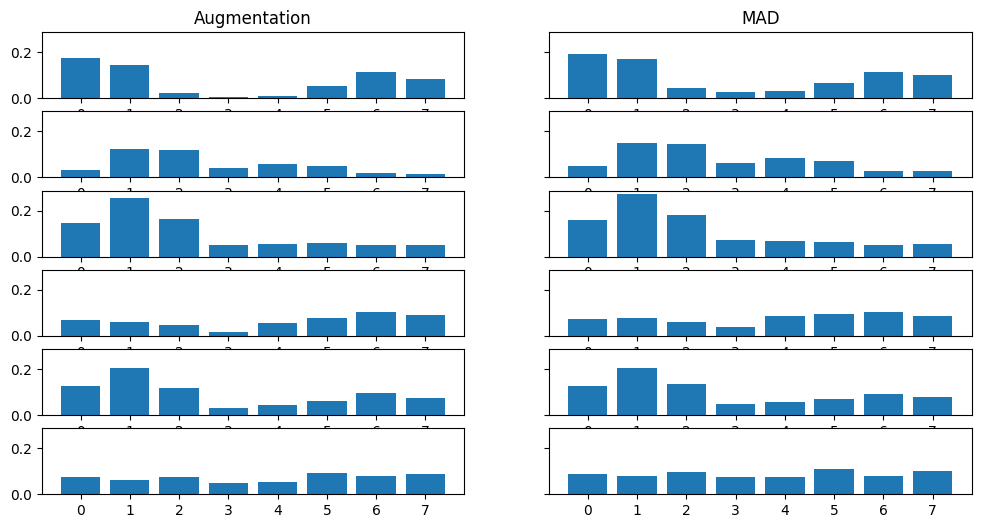

In [219]:
fig, axs = plt.subplots(6, 2, figsize=(12,6), sharey=True)

for i in range(6):
    idx = i // 2
    is_pos = (i % 2) * 2 - 1
    sample_actions = torch.zeros((100, act_dim))
    sample_actions[:, idx] = 0.8 * is_pos

    sample_features = interpolate_features(base_features, base_actions, sample_actions)
    if is_pos > 0:
        action_idxs = mad_actions[:,idx] > 0
    else:
        action_idxs = mad_actions[:,idx] < 0

    mad_action_features = mad_features[action_idxs]
    assert (sample_actions.mean() - mad_actions[action_idxs].mean()) < 0.001, "Actions should have equal mean"

    axs[i,0].bar(torch.arange(0, 8), sample_features.mean(dim=0))
    axs[i,1].bar(torch.arange(0, 8), mad_action_features.mean(dim=0))

axs[0,0].set_title('Augmentation')
axs[0,1].set_title('MAD')

In [134]:
from tqdm import tqdm
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        out = self.network(x)
        return out

In [168]:
def train(model, features, actions, batch_size, epochs, lr):
    train_features = features[:-200]
    train_actions = actions[:-200]
    test_features = features[-200:]
    test_actions = actions[-200:]

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.)

    history = {"train_loss": [], "train_mae": [], "val_loss": [], "val_mae": []}
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(train_features), size=(batch_size,))
        features_batch = train_features[sample_idx]
        actions_batch = train_actions[sample_idx]
        pred = model(features_batch)
        loss = nn.SmoothL1Loss().forward(pred, actions_batch)
        mae = torch.abs(pred - actions_batch).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        with torch.no_grad():
            val_pred = model(test_features)
            val_loss = nn.SmoothL1Loss().forward(val_pred, test_actions)
            val_mae = torch.abs(val_pred - test_actions).mean()

        bar.set_description(f"e: {e}, train_loss: {loss:.2f}, val_loss: {val_loss:.2f}")
        history["train_loss"].append(loss.data.item())
        history["train_mae"].append(mae.data.item())
        history["val_loss"].append(val_loss.data.item())
        history["val_mae"].append(val_mae.data.item())
    return history

In [177]:
batch_size = 512
epochs = 5_000
lr = 3e-4

In [178]:
model = MLP(8, 3, [512, 512], 0.1)
mad_history = train(model, mad_features, mad_actions, batch_size, epochs, lr)

e: 4999, train_loss: 0.01, val_loss: 0.01: 100%|██████████| 5000/5000 [00:33<00:00, 150.78it/s]


In [179]:
model = MLP(8, 3, [512, 512], 0.1)

sample_features = interpolate_features(base_features, base_actions, mad_actions)
sample_history = train(model, sample_features, mad_actions, batch_size, epochs, lr)

  0%|          | 0/5000 [00:00<?, ?it/s]

e: 4999, train_loss: 0.01, val_loss: 0.02: 100%|██████████| 5000/5000 [00:32<00:00, 152.23it/s]


Text(0.5, 1.0, 'MAD')

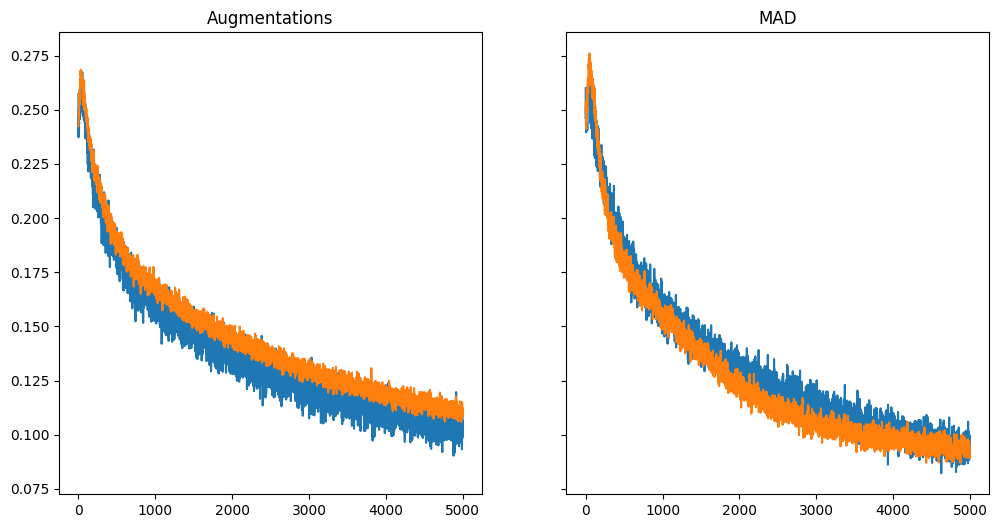

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
axs[0].plot(sample_history['train_mae'])
axs[0].plot(sample_history['val_mae'])
axs[1].plot(mad_history['train_mae'])
axs[1].plot(mad_history['val_mae'])

axs[0].set_title('Augmentations')
axs[1].set_title('MAD')

In [189]:
from itertools import product

In [213]:
all_actions = torch.tensor([x for x in product([0,1,-1], repeat=3)], dtype=torch.float32)
all_actions *= 0.8

In [215]:
model = MLP(8, 3, [512, 512], 0.1)

idxs = torch.randint(len(all_actions), (10_000,))
sample_actions = all_actions[idxs]
sample_features = interpolate_features(base_features, base_actions, sample_actions)
multi_dof_history = train(model, sample_features, sample_actions, batch_size, epochs, lr)

e: 4999, train_loss: 0.09, val_loss: 0.09: 100%|██████████| 5000/5000 [00:30<00:00, 161.68it/s]


In [207]:
model = MLP(8, 3, [512, 512], 0.1)

sample_actions = torch.rand(10_000, 3)
sample_features = interpolate_features(base_features, base_actions, sample_actions)
rand_history = train(model, sample_features, sample_actions, batch_size, epochs, lr)

e: 4999, train_loss: 0.03, val_loss: 0.03: 100%|██████████| 5000/5000 [00:30<00:00, 162.09it/s]


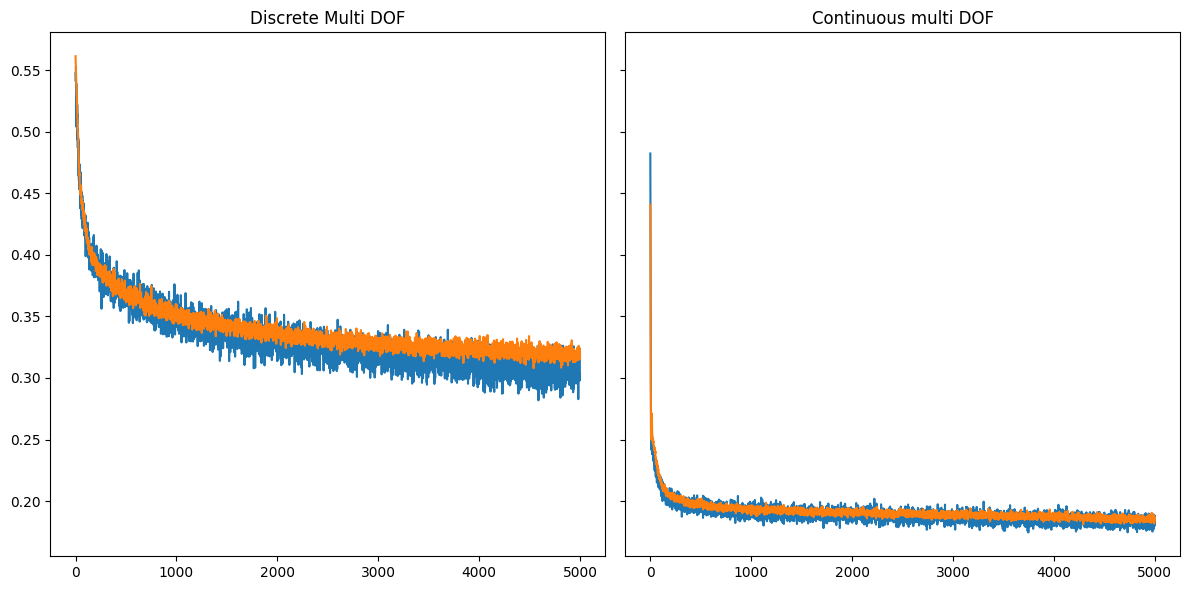

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
axs[0].plot(multi_dof_history['train_mae'])
axs[0].plot(multi_dof_history['val_mae'])
axs[1].plot(rand_history['train_mae'])
axs[1].plot(rand_history['val_mae'])

axs[0].set_title('Discrete Multi DOF')
axs[1].set_title('Continuous multi DOF')
plt.tight_layout()

In [209]:
num_augmentation = 10_000
sample_actions = torch.zeros((num_augmentation, act_dim))
random_indices = torch.randint(0, act_dim, (num_augmentation,))
sample_actions[torch.arange(num_augmentation), random_indices] = torch.rand(num_augmentation)
sample_actions *= (torch.randint(2, (num_augmentation,)) * 2 - 1)[:, None]

sample_features = interpolate_features(base_features, base_actions, sample_actions)
continuous_history = train(model, sample_features, sample_actions, batch_size, epochs, lr)

e: 4999, train_loss: 0.01, val_loss: 0.01: 100%|██████████| 5000/5000 [00:30<00:00, 162.40it/s]


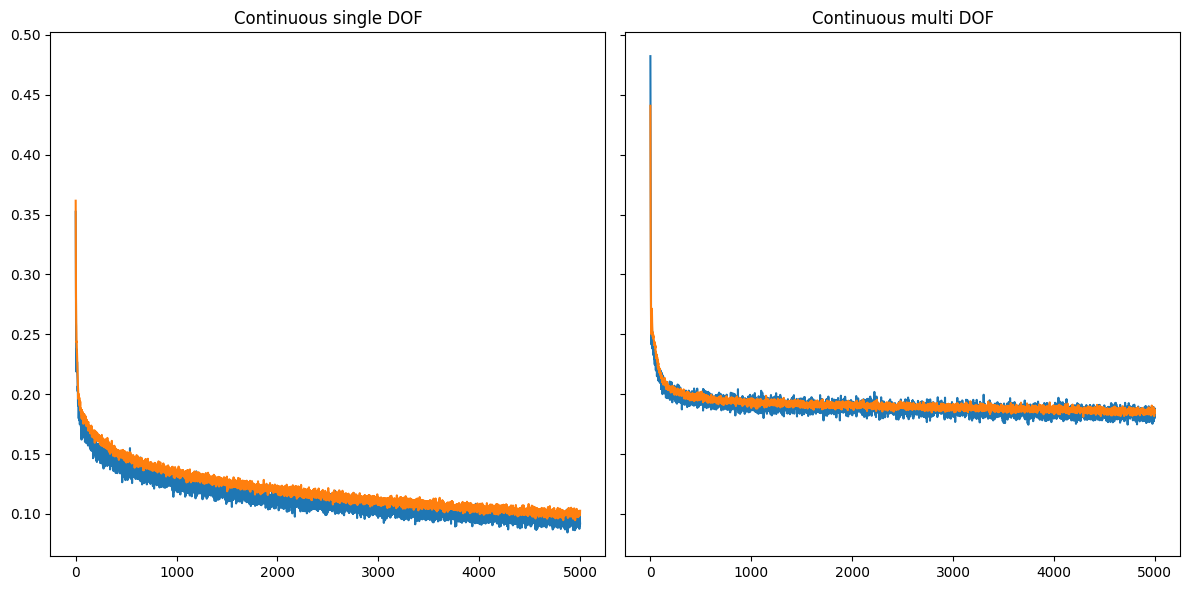

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
axs[0].plot(continuous_history['train_mae'])
axs[0].plot(continuous_history['val_mae'])
axs[1].plot(rand_history['train_mae'])
axs[1].plot(rand_history['val_mae'])

axs[0].set_title('Continuous single DOF')
axs[1].set_title('Continuous multi DOF')
plt.tight_layout()